Downloaded SPY (5240 rows).
Downloaded ^VIX (5240 rows).
Downloaded TLT (5240 rows).
Downloaded GLD (5240 rows).
Data shape: (5239, 4)

First few rows:
                 SPY      ^VIX       TLT       GLD
Date                                              
2005-01-04 -0.012295 -0.007128 -0.010536 -0.006530
2005-01-05 -0.006924  0.007838  0.005338 -0.001639
2005-01-06  0.005071 -0.036867  0.000679 -0.012261
2005-01-07 -0.001434 -0.006649  0.002261 -0.007382
2005-01-10  0.004717 -0.019462  0.001581  0.002626

Last few rows:
                 SPY      ^VIX       TLT       GLD
Date                                              
2025-10-23  0.005912 -0.072455 -0.006867  0.003994
2025-10-24  0.008139 -0.055256  0.000437 -0.003358
2025-10-27  0.011729 -0.036074  0.003383 -0.028234
2025-10-28  0.002652  0.039123  0.002612 -0.007192
2025-10-29  0.000480  0.029996 -0.010158 -0.003794

Date range: 2005-01-04 00:00:00 to 2025-10-29 00:00:00


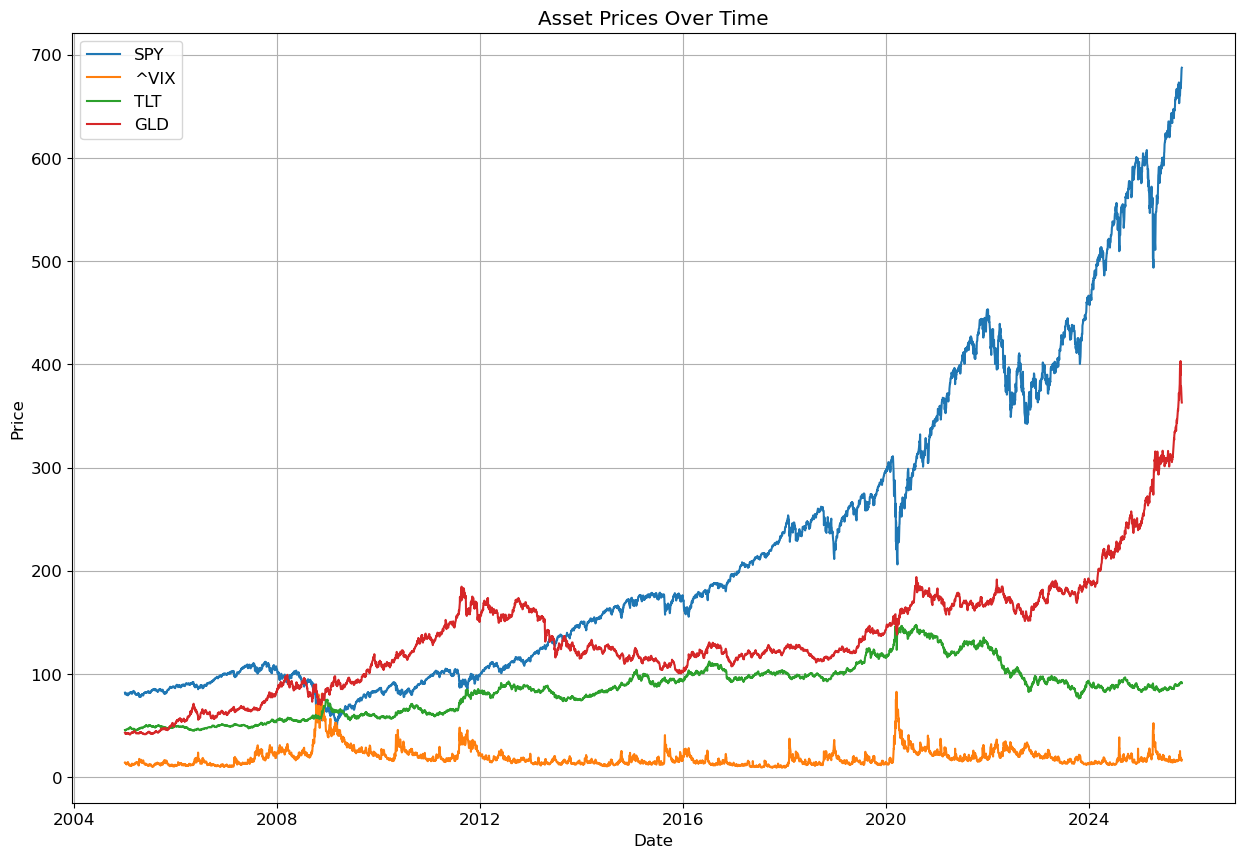

In [27]:
import time
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set up plotting style
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

def load_data(tickers, start_date, end_date, retries=3, pause=1.0):
    """
    Download close prices for each ticker, retrying transient failures.
    Returns a DataFrame indexed by date, columns are ticker symbols.
    """
    prices = pd.DataFrame()
    for t in tickers:
        attempt = 0
        local_pause = pause
        while attempt < retries:
            try:
                df = yf.download(t, start=start_date, end=end_date, auto_adjust=True, progress=False)
                if df is None or df.empty:
                    raise ValueError("No data returned")
                # Prefer standard 'Close' column but handle casing and multi-indexes
                if 'Close' in df.columns:
                    col = 'Close'
                else:
                    close_cols = [c for c in df.columns if str(c).lower() == 'close']
                    if close_cols:
                        col = close_cols[0]
                    else:
                        numeric_cols = df.select_dtypes(include='number').columns
                        if len(numeric_cols) > 0:
                            col = numeric_cols[-1]
                        else:
                            raise KeyError("No numeric price column found")
                prices[t] = df[col]
                print(f"Downloaded {t} ({len(df)} rows).")
                break
            except Exception as e:
                attempt += 1
                if attempt < retries:
                    print(f"Warning: failed to download {t} (attempt {attempt}/{retries}): {e}. Retrying in {local_pause}s...")
                    time.sleep(local_pause)
                    local_pause *= 1.5
                else:
                    print(f"Failed to download {t} after {retries} attempts: {e}. Skipping.")
                    break
    # drop columns that are all-NaN, ensure datetime index and sorted
    prices = prices.dropna(how='all')
    prices.index = pd.to_datetime(prices.index)
    prices = prices.sort_index()
    return prices

def calculate_returns(data, periods=1):
    # Calculate log returns; these are time-additive which is preferred in finance modeling
    returns = np.log(data / data.shift(periods))
    returns = returns.dropna()
    return returns

if __name__ == "__main__":
    # Defining our universe and time period
    # using SPY, ^VIX (volatility), TLT (bonds), GLD (gold)
    tickers = ['SPY', '^VIX', 'TLT', 'GLD']
    start_date = '2005-01-01'
    end_date = '2025-10-30'
    price_data = load_data(tickers, start_date, end_date)
    returns_data = calculate_returns(price_data)
    print(f"Data shape: {returns_data.shape}")
    print("\nFirst few rows:")
    print(returns_data.head())
    print("\nLast few rows:")
    print(returns_data.tail())
    print(f"\nDate range: {returns_data.index.min()} to {returns_data.index.max()}")
    
    # Plot the price data
    plt.figure(figsize=(15, 10))
    for col in price_data.columns:
        plt.plot(price_data.index, price_data[col], label=col)
    plt.title('Asset Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

Downloaded SPY (5240 rows).
Downloaded ^VIX (5240 rows).
Downloaded TLT (5240 rows).
Downloaded GLD (5240 rows).
Feature set shape: (5180, 7)
Features columns: ['spy_vol_20d', 'spy_vol_60d', 'vix_level', 'gold_equity_corr_60d', 'risk_on_off_20d', 'spy_skew_60d', 'spy_kurt_60d']
Feature set shape: (5180, 7)
Features columns: ['spy_vol_20d', 'spy_vol_60d', 'vix_level', 'gold_equity_corr_60d', 'risk_on_off_20d', 'spy_skew_60d', 'spy_kurt_60d']


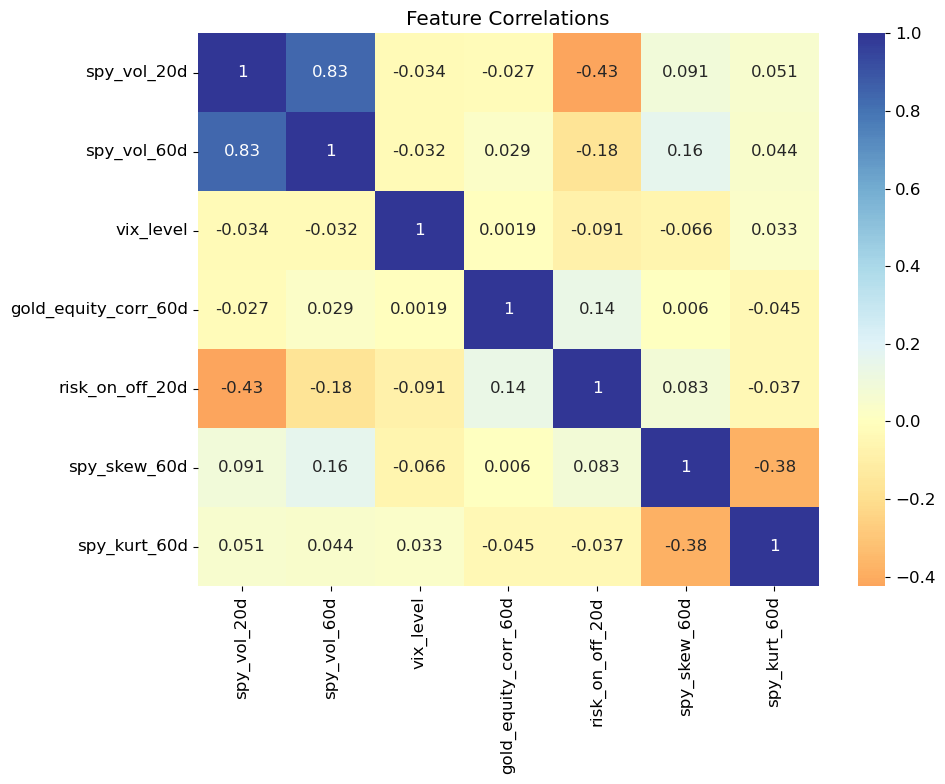

In [28]:
from scipy.stats import skew, kurtosis

def create_features(returns_data, lookback_periods=[20, 60]):
    """
    Create a rich set of features for regime detection.
    Features are rolling volatility, correlations, and risk metrics.
    """
    features_df = pd.DataFrame(index=returns_data.index)
    
    # Rolling volatility for SPY
    for window in lookback_periods:
        features_df[f'spy_vol_{window}d'] = returns_data['SPY'].rolling(window).std()
    
    # VIX level (if available)
    if '^VIX' in returns_data.columns:
        features_df['vix_level'] = returns_data['^VIX']
    
    # Gold-Equity correlation (60-day rolling)
    if 'GLD' in returns_data.columns:
        features_df['gold_equity_corr_60d'] = returns_data['SPY'].rolling(60).corr(returns_data['GLD'])
    
    # Risk-on/Risk-off indicator (20-day rolling mean difference)
    if 'TLT' in returns_data.columns:
        features_df['risk_on_off_20d'] = (returns_data['SPY'].rolling(20).mean() - 
                                         returns_data['TLT'].rolling(20).mean())
    
    # SPY rolling skewness
    features_df['spy_skew_60d'] = returns_data['SPY'].rolling(60).apply(
        lambda x: skew(x.dropna()) if len(x.dropna()) > 2 else np.nan
    )
    
    # SPY rolling kurtosis
    features_df['spy_kurt_60d'] = returns_data['SPY'].rolling(60).apply(
        lambda x: kurtosis(x.dropna()) if len(x.dropna()) > 2 else np.nan
    )
    
    # Drop rows with any NaN values
    features_df = features_df.dropna()
    
    print(f"Feature set shape: {features_df.shape}")
    print(f"Features columns: {features_df.columns.tolist()}")
    
    return features_df

# Test feature creation
if __name__ == "__main__":
    tickers = ['SPY', '^VIX', 'TLT', 'GLD']
    start_date = '2005-01-01'
    end_date = '2025-10-30'
    
    price_data = load_data(tickers, start_date, end_date)
    returns_data = calculate_returns(price_data)
    features = create_features(returns_data)
    
    # Plot feature correlations
    plt.figure(figsize=(10, 8))
    sns.heatmap(features.corr(), annot=True, cmap='RdYlBu', center=0)
    plt.title('Feature Correlations')
    plt.tight_layout()
    plt.show()

DIMENSIONAL REDUCTION AND CLUSTERING - "FINDING HIDDEN PATTERNS"

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import plotly.express as px


def build_clustering_model(features_df):
    """
    Standardize the features, reduce dimensionality, and fit a GMM model.
    Returns a results DataFrame that contains the original features, PC1/PC2 and Regime labels.
    """
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_df)

    # Dimensional reduction with PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(features_scaled)
    pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=features_df.index)

    print(f"Explained variance by PC1 and PC2: {pca.explained_variance_ratio_}")

    # Optimal number of clusters (1..7)
    n_components = np.arange(1, 8)
    models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(features_scaled) for n in n_components]
    bic_scores = [model.bic(features_scaled) for model in models]

    plt.figure(figsize=(10, 6))
    plt.plot(n_components, bic_scores, 'bo-', alpha=0.7, linewidth=2, markersize=8)
    plt.xlabel('Number of Components (Regimes)')
    plt.ylabel('Bayesian Information Criterion (BIC)')
    plt.title('GMM Model Selection: BIC vs. Number of Components')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Select the number with the lowest BIC
    optimal_n = n_components[np.argmin(bic_scores)]
    print(f"Optimal number of regimes (components) according to BIC: {optimal_n}")

    # Fit final GMM
    final_gmm = GaussianMixture(n_components=optimal_n, covariance_type='full', random_state=42)
    regime_labels = final_gmm.fit_predict(features_scaled)

    # Build results DataFrame that contains the original features + PCA + regime label
    results_df = features_df.copy()
    results_df['PC1'] = pc_df['PC1']
    results_df['PC2'] = pc_df['PC2']
    results_df['Regime'] = regime_labels
    results_df['date'] = results_df.index  # explicit column for interactive hover

    # Calculate silhouette score to assess clustering quality (requires >1 cluster)
    silhouette_avg = None
    if len(np.unique(regime_labels)) > 1:
        silhouette_avg = silhouette_score(features_scaled, regime_labels)
        print(f"Silhouette Score: {silhouette_avg:.4f}")
    else:
        print("Only one regime found; silhouette score not computed.")

    return results_df, final_gmm, scaler, pca, silhouette_avg


def visualize_clusters(results_df):
    """
    Create static scatter plot of PC1 vs PC2 colored by Regime.
    """
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=results_df, x='PC1', y='PC2', hue='Regime', palette='viridis', s=50, alpha=0.8)
    plt.title('Market Regimes Identified by GMM (PCA-reduced space)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Regime')
    plt.grid(True, alpha=0.3)
    plt.show()

# Note: this function returns results_df which already contains feature columns used below for hover_data


C:\Users\JEKUGA BRANDON\AppData\Local\Temp\ipykernel_14932\171069285.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

C:\Users\JEKUGA BRANDON\AppData\Local\Temp\ipykernel_14932\171069285.py:26: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



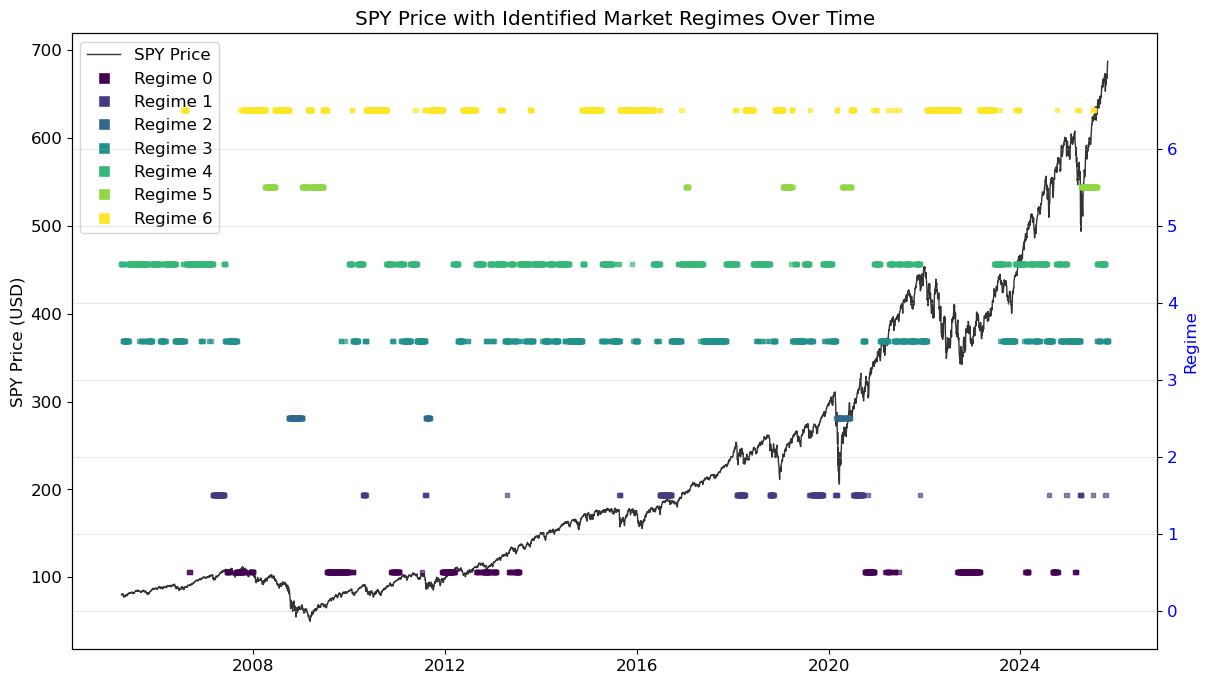

In [30]:
# Interactive scatter of PCA reduced space with hover info (uses columns in results_df)
if 'date' not in results_df.columns:
    results_df['date'] = results_df.index

# Ensure the hover columns exist before requesting them
hover_cols = [c for c in ['spy_vol_20d', 'vix_level'] if c in results_df.columns]
fig = px.scatter(results_df, x='PC1', y='PC2', color='Regime',
                 title='Interactive View of Market Regimes',
                 hover_data=['date'] + hover_cols)
fig.show()

# Static time-series plot of SPY with regime markers
plt.figure(figsize=(14, 8))
# plotting SPY price
spy_price = yf.download('SPY', start=results_df.index.min(), end=results_df.index.max(), progress=False)['Close']

ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(spy_price.index, spy_price, color='black', alpha=0.8, linewidth=1, label='SPY Price')
ax1.set_ylabel('SPY Price (USD)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Plot regime as colored scatter on the secondary axis (centered inside integer bands)
unique_regimes = sorted(results_df['Regime'].unique())
colors = plt.cm.get_cmap('viridis', len(unique_regimes))
regime_color_map = {r: colors(i) for i, r in enumerate(unique_regimes)}

ax2.scatter(results_df.index, results_df['Regime'] + 0.5, c=results_df['Regime'].map(regime_color_map),
            s=10, marker='s', alpha=0.6)
ax2.set_ylim(-0.5, max(unique_regimes) + 1.5)
ax2.set_ylabel('Regime', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_yticks(unique_regimes)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2 = [plt.Line2D([0], [0], marker='s', color='w', label=f'Regime {r}',
                     markerfacecolor=regime_color_map[r], markersize=8) for r in unique_regimes]
labels2 = [f'Regime {r}' for r in unique_regimes]
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('SPY Price with Identified Market Regimes Over Time')
plt.grid(True, alpha=0.3)
plt.show()

Downloaded SPY (5240 rows).
Downloaded ^VIX (5240 rows).
Downloaded TLT (5240 rows).
Downloaded GLD (5240 rows).
Feature set shape: (5180, 7)
Features columns: ['spy_vol_20d', 'spy_vol_60d', 'vix_level', 'gold_equity_corr_60d', 'risk_on_off_20d', 'spy_skew_60d', 'spy_kurt_60d']
Explained variance by PC1 and PC2: [0.29097451 0.2053321 ]
Feature set shape: (5180, 7)
Features columns: ['spy_vol_20d', 'spy_vol_60d', 'vix_level', 'gold_equity_corr_60d', 'risk_on_off_20d', 'spy_skew_60d', 'spy_kurt_60d']
Explained variance by PC1 and PC2: [0.29097451 0.2053321 ]


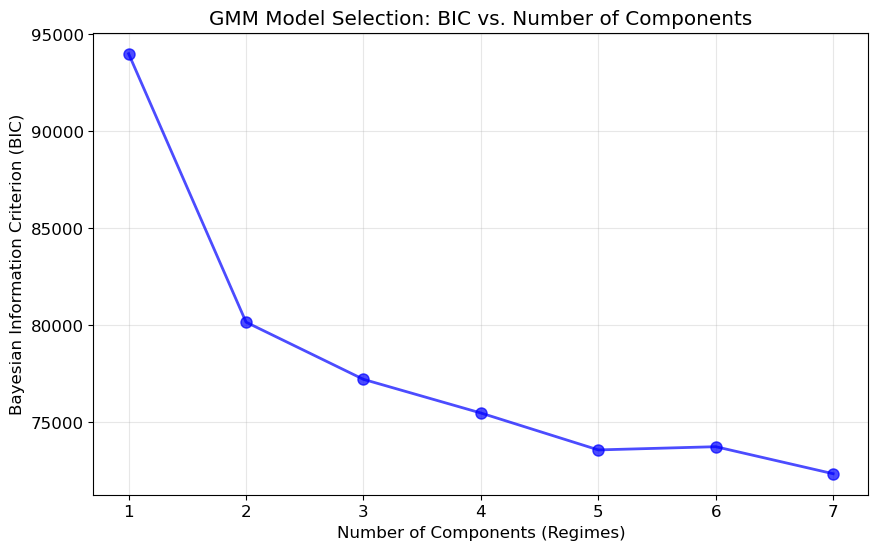

Optimal number of regimes (components) according to BIC: 7
Silhouette Score: 0.0535
Silhouette Score: 0.0535


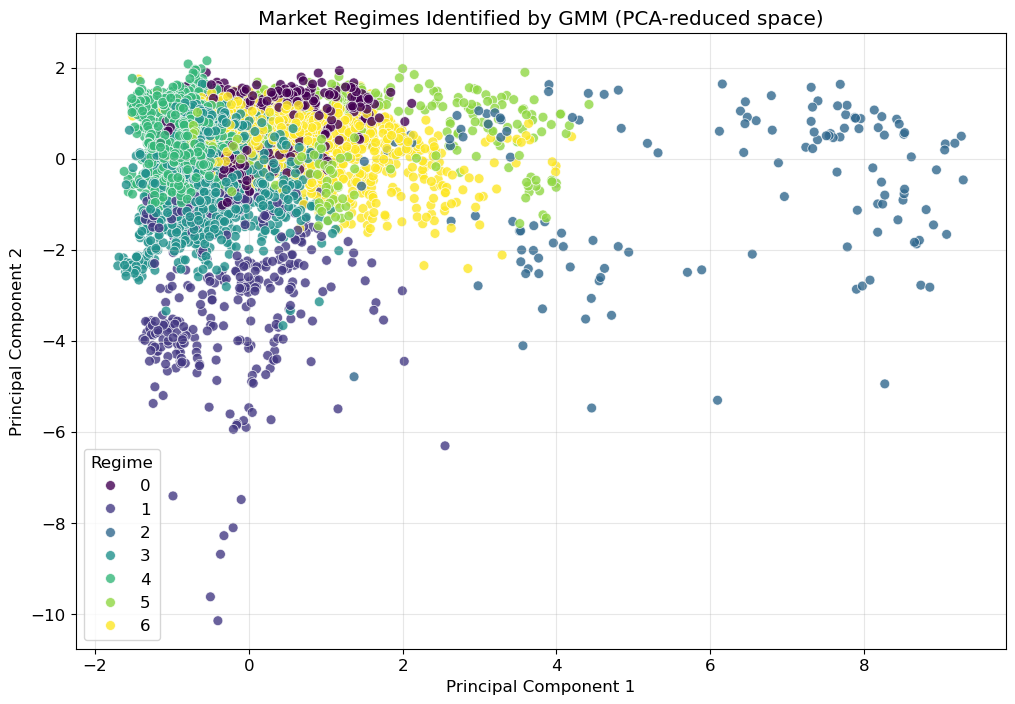


Summary:
Data range: 2005-03-31 00:00:00 to 2025-10-29 00:00:00
Number of regimes identified: 7
Clustering quality (silhouette score): 0.053


In [31]:
# Main execution block - using functions defined above
tickers = ['SPY', '^VIX', 'TLT', 'GLD']
start_date = '2005-01-01'
end_date = '2025-10-30'

# Load and prepare data using our defined functions
price_data = load_data(tickers, start_date, end_date)
returns_data = calculate_returns(price_data)
features = create_features(returns_data)

# Build model and visualize results
results_df, model, scaler, pca, score = build_clustering_model(features)
visualize_clusters(results_df)

# Print summary statistics
print("\nSummary:")
print(f"Data range: {results_df.index.min()} to {results_df.index.max()}")
print(f"Number of regimes identified: {len(results_df['Regime'].unique())}")
if score:
    print(f"Clustering quality (silhouette score): {score:.3f}")

Regime Analysis and Backtesting - "The Proof is in the Pudding

In [38]:
def analyze_regime_performance(results_df):
    """
    Analyze the characteristics and forward performance of SPY in each identified regime.

    Calculates next-day (forward) log returns for SPY aligned to the index of results_df,
    summarizes statistics by regime, prints average feature values per regime, and
    plots the distribution of forward returns for each regime.

    Returns (analysis_df, summary_stats)
    """

    # Download SPY price and align to results index
    spy_price = yf.download('SPY', start=results_df.index.min(), end=results_df.index.max(), progress=False)
    if 'Close' in spy_price.columns:
        spy_close = spy_price['Close']
    else:
        # fallback to any numeric column
        numeric_cols = spy_price.select_dtypes(include='number').columns
        if len(numeric_cols) == 0:
            raise KeyError('Could not find numeric price column for SPY')
        spy_close = spy_price[numeric_cols[-1]]

    aligned_price = spy_close.reindex(results_df.index).ffill()

    # compute next-period (forward) log returns
    forward_returns = np.log(aligned_price.shift(-1) / aligned_price)

    analysis_df = results_df.copy()
    analysis_df['SPY_Forward_Return'] = forward_returns

    # Summarize statistics by regime
    def ann_sharpe(series):
        series = series.dropna()
        if len(series) < 2 or series.std() == 0:
            return np.nan
        return (series.mean() * 252) / (series.std() * np.sqrt(252))

    grouped = analysis_df.groupby('Regime')['SPY_Forward_Return']
    summary_stats = grouped.agg(['count', 'mean', 'std', 'min', 'max']).rename(columns=str)
    # add ann_sharpe
    summary_stats['ann_sharpe'] = grouped.apply(ann_sharpe)
    # expressed mean as pct for readability
    summary_stats['mean_pct'] = summary_stats['mean'] * 100
    summary_stats = summary_stats.round(6)

    print("=== Performance Summary by Regime ===")
    print(summary_stats)

    # Characterize the regime by their average feature values
    exclude = ['Regime', 'PC1', 'PC2', 'date']
    feature_columns = [col for col in results_df.columns if col not in exclude]
    if feature_columns:
        regime_characteristics = analysis_df.groupby('Regime')[feature_columns].mean().round(6)
        print("\n=== Average Feature Values by Regime ===")
        print(regime_characteristics)
    else:
        regime_characteristics = pd.DataFrame()

    # Visualise the distribution of forward returns in each regime
    plt.figure(figsize=(12, 6))
    plotted = False
    for regime in sorted(analysis_df['Regime'].unique()):
        regime_data = analysis_df[analysis_df['Regime'] == regime]['SPY_Forward_Return'].dropna()
        if len(regime_data) == 0:
            continue
        sns.kdeplot(regime_data * 100, label=f"Regime {regime}", fill=True, alpha=0.5)
        plotted = True

    if plotted:
        plt.xlabel('Daily Forward Return (%)')
        plt.ylabel('Density')
        plt.title('Distribution of SPY Forward Return by Regime')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("No forward return data available to plot.")

    return analysis_df, summary_stats
    plt.figure(figsize=(14, 8))
    for regime in sorted(analysis_df['Regime'].unique()):
        regime_return = analysis_df[analysis_df['Regime'] == regime]['SPY_Forward_return']
        cumulative_returns = (1 + regime_returns).cumprod()
        plt.plot(cumulative_returns.index, cumulative_returns, label=f'Regime {regime}', linewidth=2)

        plt.yscale('log')
        plt.ylabel('Cumulatibve Return (Log Scale)')
        plt.title('Hypothetical Growth of $1 Invested ONLY during Regime')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        return analysis_df, summary_stats
    




C:\Users\JEKUGA BRANDON\AppData\Local\Temp\ipykernel_14932\1476393937.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True



=== Performance Summary by Regime ===
        count      mean       std       min       max  ann_sharpe  mean_pct
Regime                                                                     
0         549  0.001215  0.009945 -0.034776  0.053497    1.939806  0.121521
1         322  0.000825  0.013224 -0.067340  0.099863    0.990148  0.082481
2         141  0.000144  0.038796 -0.115887  0.135577    0.058781  0.014365
3        1263  0.000475  0.008861 -0.050536  0.043099    0.850106  0.047452
4        1493  0.000270  0.006250 -0.039841  0.024562    0.684731  0.026958
5         297  0.000602  0.014746 -0.059377  0.069367    0.647757  0.060170
6        1114  0.000009  0.013850 -0.081602  0.057900    0.010064  0.000878

=== Average Feature Values by Regime ===
        spy_vol_20d  spy_vol_60d  vix_level  gold_equity_corr_60d  \
Regime                                                              
0          0.010617     0.011412  -0.009134              0.429062   
1          0.009353     0.009

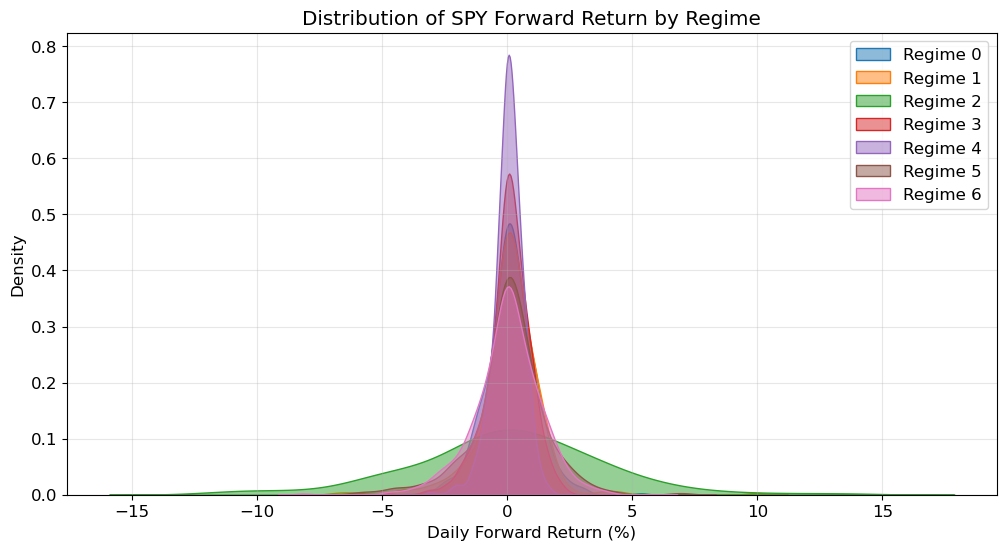

In [39]:

analysis_df, summary_stats = analyze_regime_performance(results_df)

In [ ]:
def implement_naive_regime_strategy(analysis_df, initial_capital=100000):
    """
    Implements a simple regime-based trading strategy:
    - Long SPY in regimes with positive expected return (based on in-sample mean)
    - Cash (flat) in regimes with negative expected return
    
    Returns DataFrame with strategy results and metrics
    """
    # Calculate regime mean returns
    regime_means = analysis_df.groupby('Regime')['SPY_Forward_Return'].mean()
    
    # Generate signals: 1 for positive expected return regimes, 0 for negative
    analysis_df['Signal'] = analysis_df['Regime'].map(lambda x: 1 if regime_means[x] > 0 else 0)
    
    # Calculate strategy returns (shifted signals to avoid look-ahead bias)
    analysis_df['Strategy_Return'] = analysis_df['Signal'].shift(1) * analysis_df['SPY_Forward_Return']
    
    # Calculate cumulative returns for buy & hold vs strategy
    analysis_df['Cum_BH'] = (1 + analysis_df['SPY_Forward_Return']).cumprod()
    analysis_df['Cum_Strategy'] = (1 + analysis_df['Strategy_Return']).cumprod()
    
    # Scale to initial capital
    analysis_df['Portfolio_BH'] = analysis_df['Cum_BH'] * initial_capital
    analysis_df['Portfolio_Strategy'] = analysis_df['Cum_Strategy'] * initial_capital
    
    # Calculate metrics
    metrics = {}
    for name, returns in [('Buy & Hold', analysis_df['SPY_Forward_Return']), 
                         ('Strategy', analysis_df['Strategy_Return'])]:
        metrics[name] = {
            'Total Return': (returns + 1).prod() - 1,
            'Ann. Return': returns.mean() * 252,
            'Ann. Vol': returns.std() * np.sqrt(252),
            'Sharpe Ratio': (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() > 0 else 0,
            'Max Drawdown': ((1 + returns).cumprod() / (1 + returns).cumprod().cummax() - 1).min(),
        }
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(analysis_df.index, analysis_df['Portfolio_BH'], 
             label='Buy & Hold', alpha=0.7)
    plt.plot(analysis_df.index, analysis_df['Portfolio_Strategy'], 
             label='Regime Strategy', alpha=0.7)
    plt.title('Strategy Performance: Regime-Based vs Buy & Hold')
    plt.xlabel('Date')
    plt.ylabel(f'Portfolio Value (Initial ${initial_capital:,})')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # Print metrics
    print("\n=== Strategy Performance Metrics ===")
    metrics_df = pd.DataFrame(metrics).round(4)
    print(metrics_df)
    
    return analysis_df, metrics_df

# Run the strategy analysis
strategy_results, strategy_metrics = implement_naive_regime_strategy(analysis_df)

# Additional strategy insights
regime_exposure = strategy_results['Signal'].value_counts(normalize=True)
print("\n=== Strategy Regime Exposure ===")
print("Percentage of time in market by signal:")
print(regime_exposure.round(4) * 100)

Downloaded SPY (5240 rows).
Downloaded ^VIX (5240 rows).
Downloaded TLT (5240 rows).
Downloaded GLD (5240 rows).
Feature set shape: (5180, 7)
Features columns: ['spy_vol_20d', 'spy_vol_60d', 'vix_level', 'gold_equity_corr_60d', 'risk_on_off_20d', 'spy_skew_60d', 'spy_kurt_60d']
Explained variance by PC1 and PC2: [0.29097451 0.2053321 ]
Feature set shape: (5180, 7)
Features columns: ['spy_vol_20d', 'spy_vol_60d', 'vix_level', 'gold_equity_corr_60d', 'risk_on_off_20d', 'spy_skew_60d', 'spy_kurt_60d']
Explained variance by PC1 and PC2: [0.29097451 0.2053321 ]


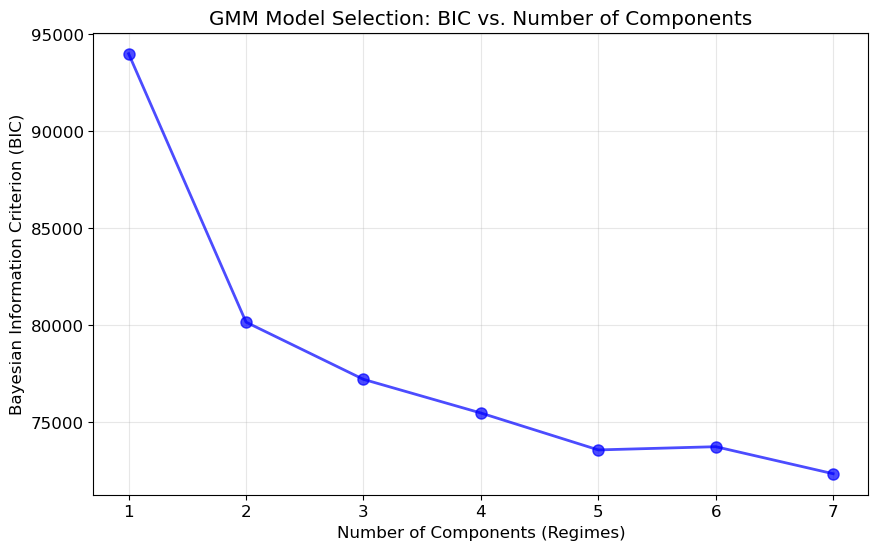

Optimal number of regimes (components) according to BIC: 7
Silhouette Score: 0.0535
Silhouette Score: 0.0535


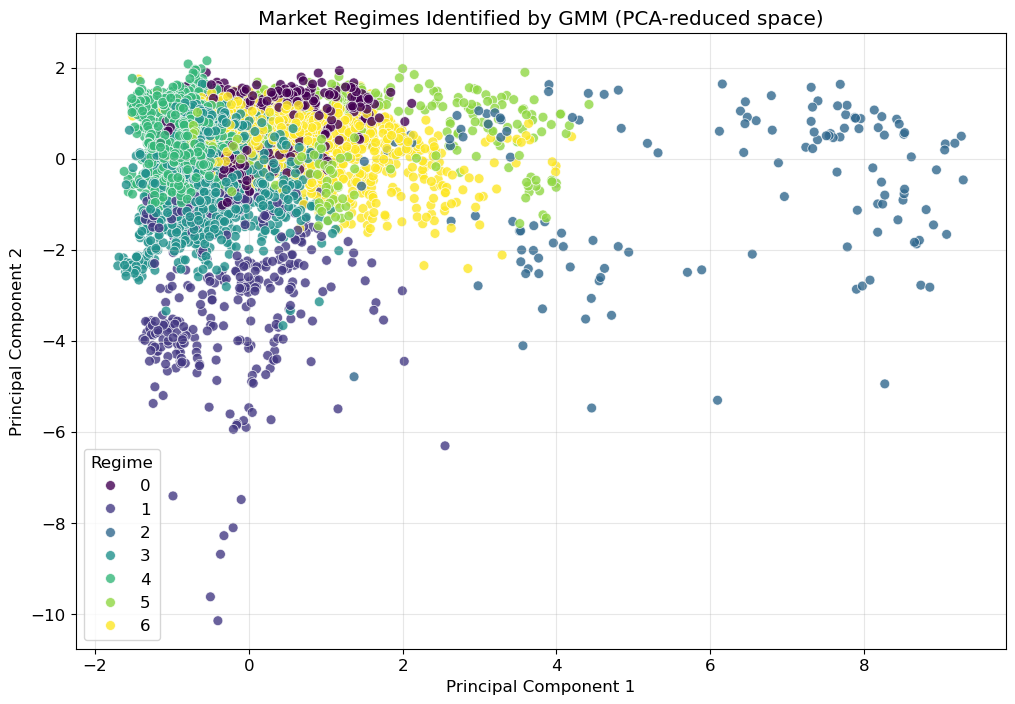

C:\Users\JEKUGA BRANDON\AppData\Local\Temp\ipykernel_14932\1476393937.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True



=== Performance Summary by Regime ===
        count      mean       std       min       max  ann_sharpe  mean_pct
Regime                                                                     
0         549  0.001215  0.009945 -0.034776  0.053497    1.939806  0.121521
1         322  0.000825  0.013224 -0.067340  0.099863    0.990148  0.082481
2         141  0.000144  0.038796 -0.115887  0.135577    0.058781  0.014365
3        1263  0.000475  0.008861 -0.050536  0.043099    0.850106  0.047452
4        1493  0.000270  0.006250 -0.039841  0.024562    0.684731  0.026958
5         297  0.000602  0.014746 -0.059377  0.069367    0.647757  0.060170
6        1114  0.000009  0.013850 -0.081602  0.057900    0.010064  0.000878

=== Average Feature Values by Regime ===
        spy_vol_20d  spy_vol_60d  vix_level  gold_equity_corr_60d  \
Regime                                                              
0          0.010617     0.011412  -0.009134              0.429062   
1          0.009353     0.009

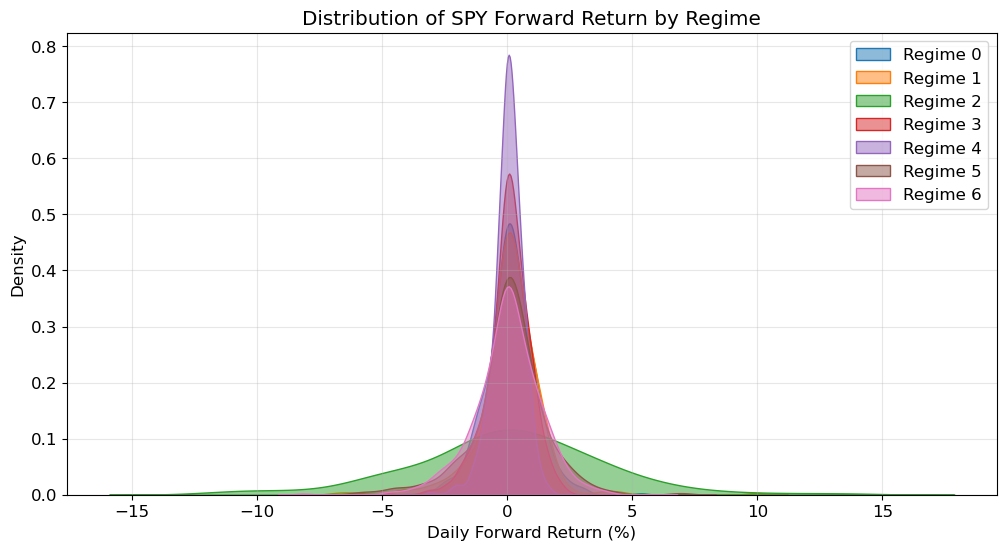


Run complete.
Number of regimes identified: 7
Silhouette score: 0.053


In [42]:
# Execute the full pipeline using functions already defined in this notebook
# (avoid importing missing external modules)

tickers = ['SPY', '^VIX', 'TLT', 'GLD']
start_date = '2005-01-01'
end_date = '2025-10-30'

# Load and prepare data using our defined functions
price_data = load_data(tickers, start_date, end_date)
returns_data = calculate_returns(price_data)
features = create_features(returns_data)

# Build model and visualize results
results, model, scaler, pca, score = build_clustering_model(features)

# Visualize clusters (static + interactive cells exist elsewhere)
try:
    visualize_clusters(results)
except Exception as e:
    print(f"visualize_clusters raised an exception: {e}")

# Analyze regime performance
analysis_df, stats = analyze_regime_performance(results)

print("\nRun complete.")
print(f"Number of regimes identified: {len(results['Regime'].unique())}")
if score:
    print(f"Silhouette score: {score:.3f}")